# MNIST Project

## Imports

In [4]:
import torch
from torch import Tensor 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
import src.dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

## Loading the Data

In [5]:
N = 1000
train_X, train_Y, train_Class, test_X, test_Y, test_Class = prologue.generate_pair_sets(N)

In [6]:
%%capture
mu, std = train_X.mean(), train_X.std()
train_X.sub_(mu).div_(std)
test_X.sub_(mu).div_(std)

## Model 1: Naive convnet
For the first model, we create a naive convnet, not taking into account the structrue of the channels.

In [4]:
class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [5]:
def train_model(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, verbose=False):
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        if(verbose): print(compute_nb_errors(model, train_X, train_Y, minibatch_size))
    return model

In [6]:
def train_model_path(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, test_X, test_Y, verbose=False):
    train_error = []
    test_error = []
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_error.append(compute_nb_errors(model, train_X, train_Y, minibatch_size))
        test_error.append(compute_nb_errors(model, test_X, test_Y, minibatch_size))
        if(verbose): print(compute_nb_errors(model, train_X, train_Y, minibatch_size))
    return model, train_error, test_error

In [7]:
def compute_nb_errors(model, data_input, data_target, minibatch_size):
    nb_data_errors = 0
    for b in range(0, data_input.size(0), minibatch_size):
        out = model(data_input.narrow(0, b, minibatch_size))
        _, pred = torch.max(out.data, 1)
        for k in range(minibatch_size):
            if data_target[b+k] != pred[k]:
                nb_data_errors += 1
    return nb_data_errors

In [8]:
model1 = convNet()
model1, train_path, test_path = train_model_path(model1, nn.CrossEntropyLoss(), optim.SGD(model1.parameters(), lr=1e-1), \
                                                 100, 100, train_X, train_Y, test_X, test_Y, verbose=False)

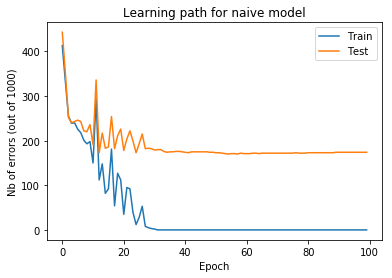

Final Test Error: 174/1000


In [9]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for naive model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(model1, test_X, test_Y, 100)))

We observe that this model does not manage to learn the mapping very well.

## Model 2: Using transfer learning

### Part 1: Study of a good functioning digit detection network for 28x28 images

In [10]:
train_input, train_target, test_input, test_target = \
    prologue.load_data(one_hot_labels = False, normalize = True, flatten = False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [11]:
train_input, train_target = Variable(train_input), Variable(train_target)
model = Net()

In [12]:
model = train_model(model, nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=1e-1), 50, 100, train_input, train_target)

In [13]:
print('Final Test Error: {}/1000'.format(compute_nb_errors(model, test_input, test_target, 100)))

Final Test Error: 61/1000


### Part 2: Adapting the network to 14x14 images

In [14]:
# fist, create the training and testing dataset
train_target_14px = torch.cat((train_Class[:,0], train_Class[:,1]))
train_input_14px = torch.cat((train_X[:,0,:,:].view(1000,1,14,14), train_X[:,1,:,:].view(1000,1,14,14)))

test_target_14px = torch.cat((test_Class[:,0], test_Class[:,1]))
test_input_14px = torch.cat((test_X[:,0,:,:].view(1000,1,14,14), test_X[:,1,:,:].view(1000,1,14,14)))

train_input_14px, train_target_14px = Variable(train_input_14px), Variable(train_target_14px)

In [15]:
class Net_14px(nn.Module):
    def __init__(self):
        super(Net_14px, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [16]:
model_14px = Net_14px()
model_14px, train_path, test_path = train_model_path(model_14px, nn.CrossEntropyLoss(), optim.SGD(model_14px.parameters(), lr=1e-1), 50, 100, \
                         train_input_14px, train_target_14px, test_input_14px, test_target_14px, verbose=False)

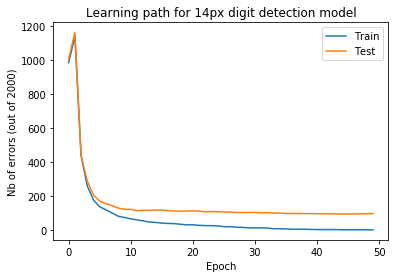

Final Test Error: 97/2000


In [17]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for 14px digit detection model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 2000)')
plt.legend()
plt.show()
print('Final Test Error: {}/2000'.format(compute_nb_errors(model_14px, test_input_14px, test_target_14px, 100)))


Now, let's define the siamese model with parameter sharing:

In [18]:
class siamese_Net(nn.Module):
    def __init__(self):
        super(siamese_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc3 = nn.Linear(200, 10)
        self.fc4 = nn.Linear(10,2)

    def forward(self, x):
        x1 = F.relu(F.max_pool2d(self.conv1(x[:,0,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x1 = F.relu(self.fc1(x1.view(-1, 256)))
        x2 = F.relu(F.max_pool2d(self.conv1(x[:,1,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x2 = F.relu(self.fc1(x2.view(-1, 256)))
        x = F.relu(self.fc3(torch.cat((x1.view(-1,100), x2.view(-1, 100)), 1)))
        x = self.fc4(x)
        return x

In [19]:
sNet = siamese_Net()

In [20]:
torch.save(model_14px.state_dict(), 'networks/model_14px.pt')

In [21]:
sNet.load_state_dict(torch.load('networks/model_14px.pt'), strict=False)

In [22]:
sNet, train_path, test_path = train_model_path(sNet, nn.CrossEntropyLoss(), optim.SGD(sNet.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

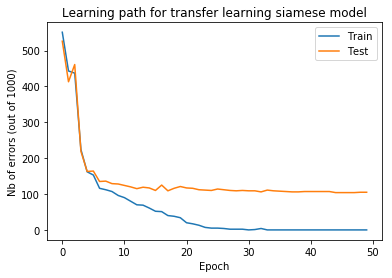

Final Test Error: 105/1000


In [23]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for transfer learning siamese model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet, test_X, test_Y, 100)))

# Model 3: Siamese Net without Pretraining

In [24]:
sNet2 = siamese_Net()

In [25]:
sNet2, train_path, test_path = train_model_path(sNet2, nn.CrossEntropyLoss(), optim.SGD(sNet2.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

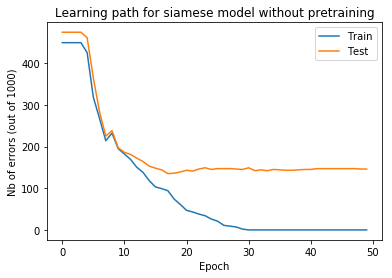

Final Test Error: 146/1000


In [26]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for siamese model without pretraining')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet2, test_X, test_Y, 100)))

## Model 4: With Pretraining, not updating the convolution layer parameters:
Therefore keeping the feature extractor

In [27]:
sNet3 = siamese_Net()

In [28]:
sNet3.load_state_dict(torch.load('networks/model_14px.pt'), strict=False)

In [29]:
for p in sNet3.conv1.parameters():
    p.requires_grad = False
for p in sNet3.conv2.parameters():
    p.requires_grad = False

In [30]:
sNet3, train_path, test_path = train_model_path(sNet3, nn.CrossEntropyLoss(), optim.SGD(sNet3.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

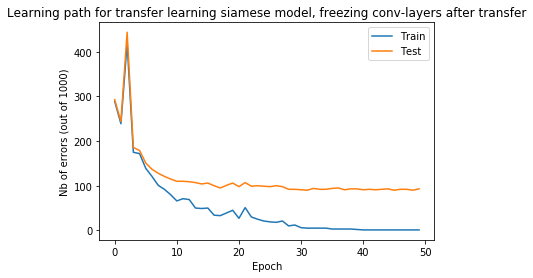

Final Test Error: 93/1000


In [31]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for transfer learning siamese model, freezing conv-layers after transfer')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet3, test_X, test_Y, 100)))

## Model 5: Training with auxiliary loss:

In [7]:
def compute_nb_errors_aux(model, data_input, data_target, minibatch_size):
    nb_data_errors = 0
    for b in range(0, data_input.size(0), minibatch_size):
        out = model(data_input.narrow(0, b, minibatch_size))
        _, pred = torch.max(out[0].data, 1)
        for k in range(minibatch_size):
            if data_target[b+k] != pred[k]:
                nb_data_errors += 1
    return nb_data_errors

In [20]:
class siamese_Net2(nn.Module):
    def __init__(self):
        super(siamese_Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(200, 10)
        self.fc4 = nn.Linear(10,2)

    def forward(self, x):
        x1 = F.relu(F.max_pool2d(self.conv1(x[:,0,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x1 = F.relu(self.fc1(x1.view(-1, 256)))
        x2 = F.relu(F.max_pool2d(self.conv1(x[:,1,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x2 = F.relu(self.fc1(x2.view(-1, 256)))
        x = F.relu(self.fc3(torch.cat((x1.view(-1,100), x2.view(-1, 100)), 1)))
        x = self.fc4(x)
        
        n1 = self.fc2(x1)
        n2 = self.fc2(x2)
        return [x, n1, n2]

In [34]:
def train_model_path_aux(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, train_class, test_X, test_Y, beta = 1, verbose=False):
    train_error = []
    test_error = []
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out[0], train_Y.narrow(0, b, minibatch_size))
            aux_loss = criterion(out[1], train_class[:,0].narrow(0, b, minibatch_size)) + \
                            criterion(out[2], train_class[:,1].narrow(0, b, minibatch_size))
            model.zero_grad()
            (loss + beta*aux_loss).backward()
            optimizer.step()
        train_error.append(compute_nb_errors_aux(model, train_X, train_Y, minibatch_size))
        test_error.append(compute_nb_errors_aux(model, test_X, test_Y, minibatch_size))
        if(verbose): print(compute_nb_errors_aux(model, train_X, train_Y, minibatch_size))
    return model, train_error, test_error

In [35]:
sNet4 = siamese_Net2()

In [36]:
sNet4, train_path, test_path = train_model_path_aux(sNet4, nn.CrossEntropyLoss(), optim.SGD(sNet4.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, train_Class, test_X, test_Y, beta = 0.5, verbose=False)

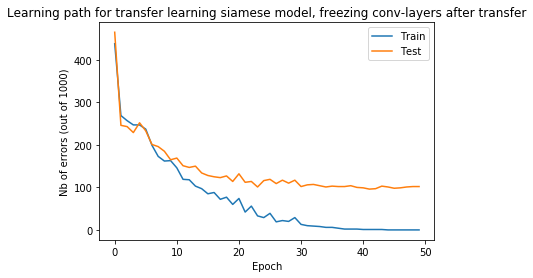

Final Test Error: 102/1000


In [37]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for siamese model with auxilary loss')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors_aux(sNet4, test_X, test_Y, 100)))

Now, we seek to find the best beta. For this, we will use 10-fold cross validation.

In [53]:
def train_model_aux(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, train_class, beta = 1, verbose=False):
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out[0], train_Y.narrow(0, b, minibatch_size))
            aux_loss = criterion(out[1], train_class[:,0].narrow(0, b, minibatch_size)) + \
                            criterion(out[2], train_class[:,1].narrow(0, b, minibatch_size))
            model.zero_grad()
            (loss + beta*aux_loss).backward()
            optimizer.step()
        if(verbose): print(compute_nb_errors_aux(model, train_X, train_Y, minibatch_size))
    return model

In [54]:
def k_fold_CV(k, train_X, train_Y, train_class, b,N_samples = 1000):
    n_errors = 0
    for j in range(k):
        snet = siamese_Net2()
        # get the split inside the fold
        t_x_v = train_X[int(N_samples*j/k):int(N_samples*(j+1)/k)]
        t_y_v = train_Y[int(N_samples*j/k):int(N_samples*(j+1)/k)]
        t_c_v = train_class[int(N_samples*j/k):int(N_samples*(j+1)/k)]
        t_x_t = torch.cat((train_X[0:int(N_samples*j/k)], train_X[int(N_samples*(j+1)/k):]),0)
        t_y_t = torch.cat((train_Y[0:int(N_samples*j/k)], train_Y[int(N_samples*(j+1)/k):]),0)
        t_c_t = torch.cat((train_class[0:int(N_samples*j/k)], train_class[int(N_samples*(j+1)/k):]),0)
            
        # train the model on the training split
        snet = train_model_aux(snet, nn.CrossEntropyLoss(), optim.SGD(sNet4.parameters(), lr=1e-1), \
                                50, 100, t_x_t, t_y_t, t_c_t, beta = b, verbose=False)
        n_errors += compute_nb_errors_aux(snet, t_x_v, t_y_v, 100)
    return n_errors

In [ ]:
plt.plot(betas, errors)

# Convnet without weight sharing
You can set beta = 0 to have no auxiliary loss

## Part 1: no auxiliary loss

In [9]:
class siamese_Net_no_WS(nn.Module):
    def __init__(self):
        super(siamese_Net_no_WS, self).__init__()
        self.conv1a = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1a = nn.Linear(256, 100)
        self.fc2a = nn.Linear(100, 10)
        self.conv1b = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2b = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1b = nn.Linear(256, 100)
        self.fc2b = nn.Linear(100, 10)
        self.fc3 = nn.Linear(200, 10)
        self.fc4 = nn.Linear(10,2)

    def forward(self, x):
        x1 = F.relu(F.max_pool2d(self.conv1a(x[:,0,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x1 = F.relu(F.max_pool2d(self.conv2a(x1), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x1 = F.relu(self.fc1a(x1.view(-1, 256)))
        x2 = F.relu(F.max_pool2d(self.conv1b(x[:,1,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x2 = F.relu(F.max_pool2d(self.conv2b(x2), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x2 = F.relu(self.fc1b(x2.view(-1, 256)))
        x = F.relu(self.fc3(torch.cat((x1.view(-1,100), x2.view(-1, 100)), 1)))
        x = self.fc4(x)
        
        n1 = self.fc2a(x1)
        n2 = self.fc2b(x2)
        return [x, n1, n2]

In [61]:
sNet_no_WS_no_al = siamese_Net_no_WS()
sNet_no_WS_no_al, train_path, test_path = train_model_path_aux(sNet_no_WS_no_al, nn.CrossEntropyLoss(), \
          optim.SGD(sNet_no_WS_no_al.parameters(), lr=1e-1), 50, 100, train_X, train_Y, train_Class, test_X, \
                                                               test_Y, beta = 0, verbose=False)

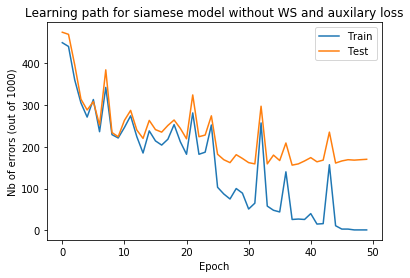

Final Test Error: 170/1000


In [62]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for siamese model without WS and auxilary loss')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors_aux(sNet_no_WS_no_al, test_X, test_Y, 100)))

## Part 2: With auxiliary loss

In [63]:
sNet_no_WS = siamese_Net_no_WS()
sNet_no_WS, train_path, test_path = train_model_path_aux(sNet_no_WS, nn.CrossEntropyLoss(), \
          optim.SGD(sNet_no_WS.parameters(), lr=1e-1), 50, 100, train_X, train_Y, train_Class, test_X, \
                                                               test_Y, beta = 0.5, verbose=False)

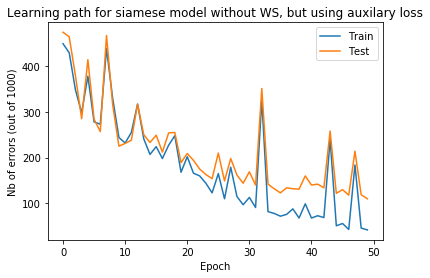

Final Test Error: 110/1000


In [65]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for siamese model without WS, but using auxilary loss')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors_aux(sNet_no_WS, test_X, test_Y, 100)))

## New Version of auxiliary Loss Weighting

Intuition behind the auxiliary loss weighting:

When implementing the auxiliary loss, it was also necessary to define how much importance the auxiliary loss should take up in the total loss mediated through the hyperparameter beta (total loss = loss + beta\*aux_loss). Three main possibilities existed: 

1) Making a random guess by e.g. setting beta to 0.5.

2) Optimizing the hyperparameter with cross-validation. However, no clear pattern for the validation error over a wide range of betas could be observed that would have motivated a specific constant value for beta.

3) Linearly decrease the importance of the auxiliary loss from initially 100% in the first epoch of training down to 0% for the last epoch. This comes from the intuition of giving first lots of importance to get better at the classification task (digit prediction) as otherwise, the task of comparing two digits does not make sense in the first place. As we continue in training, we however give more and more importance of being good at the actual task of interest: predicting whether the first digit is smaller equal than the second one.

In [23]:
def train_model_path_aux2(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, train_class, test_X, test_Y, verbose=False):
    train_error = []
    test_error = []
    for e in range(nb_epochs):
        beta = (nb_epochs - e)/nb_epochs
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out[0], train_Y.narrow(0, b, minibatch_size))
            aux_loss = criterion(out[1], train_class[:,0].narrow(0, b, minibatch_size)) + \
                            criterion(out[2], train_class[:,1].narrow(0, b, minibatch_size))
            model.zero_grad()
            ((1-beta)*loss + beta*aux_loss).backward()
            optimizer.step()
        train_error.append(compute_nb_errors_aux(model, train_X, train_Y, minibatch_size))
        test_error.append(compute_nb_errors_aux(model, test_X, test_Y, minibatch_size))
        if(verbose): print(compute_nb_errors_aux(model, train_X, train_Y, minibatch_size))
    return model, train_error, test_error

### Part 1: Used with no weight sharing

In [24]:
sNet_no_WS = siamese_Net_no_WS()
sNet_no_WS, train_path, test_path = train_model_path_aux2(sNet_no_WS, nn.CrossEntropyLoss(), \
          optim.SGD(sNet_no_WS.parameters(), lr=1e-1), 100, 100, train_X, train_Y, train_Class, test_X, \
                                                               test_Y, verbose=False)

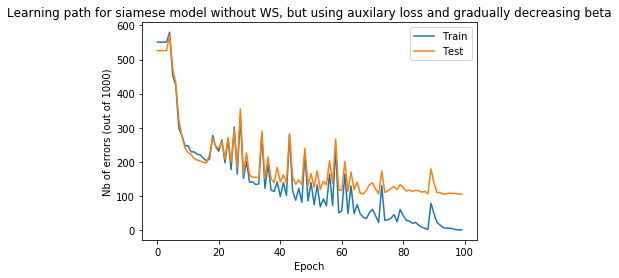

Final Test Error: 105/1000


In [25]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for siamese model without WS, but using auxilary loss and gradually decreasing beta')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors_aux(sNet_no_WS, test_X, test_Y, 100)))

### Part 2: Used with weight sharing

In [26]:
sNet = siamese_Net2()
sNet_no_WS, train_path, test_path = train_model_path_aux2(sNet, nn.CrossEntropyLoss(), \
          optim.SGD(sNet.parameters(), lr=1e-1), 100, 100, train_X, train_Y, train_Class, test_X, \
                                                               test_Y, verbose=False)

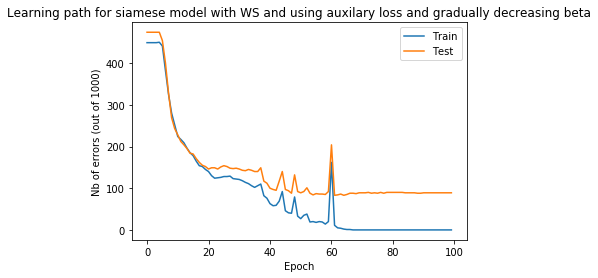

Final Test Error: 89/1000


In [27]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for siamese model with WS and using auxilary loss and gradually decreasing beta')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors_aux(sNet_no_WS, test_X, test_Y, 100)))